# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt

def plot_reward_per_episode_single(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()

def plot_reward_per_episode(reward_ep_sarsa, reward_ep_qlearning) -> None:
    episode_rewards_sarsa = np.array(reward_ep_sarsa)
    episode_rewards_qlearning = np.array(reward_ep_qlearning)

    # Se suavizan las curvas de convergencia
    episode_number = np.linspace(1, len(episode_rewards_sarsa) + 1, len(episode_rewards_sarsa) + 1)
    acumulated_rewards_sarsa = np.cumsum(episode_rewards_sarsa)
    acumulated_rewards_qlearning = np.cumsum(episode_rewards_qlearning)

    reward_per_episode_sarsa = [acumulated_rewards_sarsa[i] / episode_number[i] for i in range(len(acumulated_rewards_sarsa))]
    reward_per_episode_qlearning = [acumulated_rewards_qlearning[i] / episode_number[i] for i in range(len(acumulated_rewards_qlearning))]

    plt.figure(figsize=(10, 6))

    plt.plot(reward_per_episode_sarsa, label='SARSA')
    plt.plot(reward_per_episode_qlearning, label='Q-learning')

    plt.title("Recompensa acumulada por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa acumulada")
    plt.legend()
    plt.grid(True)
    plt.show()




def plot_steps_per_episode(timesteps_ep_sarsa, timesteps_ep_qlearning) -> None:
    episode_steps_sarsa = np.array(timesteps_ep_sarsa)
    episode_steps_qlearning = np.array(timesteps_ep_qlearning)

    plt.figure(figsize=(10, 6))

    plt.plot(np.array(range(0, len(episode_steps_sarsa))), episode_steps_sarsa, label='SARSA')
    plt.plot(np.array(range(0, len(episode_steps_qlearning))), episode_steps_qlearning, label='Q-learning')

    plt.title("Pasos (timesteps) por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos (timesteps)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep_sarsa, timesteps_ep_qlearning) -> None:
    episode_steps_sarsa = np.array(timesteps_ep_sarsa)
    episode_steps_qlearning = np.array(timesteps_ep_qlearning)

    plt.figure(figsize=(10, 6))

    # Suaviza la curva de aprendizaje para SARSA
    episode_number_sarsa = np.linspace(
        1, len(episode_steps_sarsa) + 1, len(episode_steps_sarsa) + 1)
    acumulated_steps_sarsa = np.cumsum(episode_steps_sarsa)
    steps_per_episode_sarsa = [
        acumulated_steps_sarsa[i] / episode_number_sarsa[i] for i in range(
            len(acumulated_steps_sarsa))
    ]

    # Suaviza la curva de aprendizaje para Q-learning
    episode_number_qlearning = np.linspace(
        1, len(episode_steps_qlearning) + 1, len(episode_steps_qlearning) + 1)
    acumulated_steps_qlearning = np.cumsum(episode_steps_qlearning)
    steps_per_episode_qlearning = [
        acumulated_steps_qlearning[i] / episode_number_qlearning[i] for i in range(
            len(acumulated_steps_qlearning))
    ]

    plt.plot(steps_per_episode_sarsa, label='SARSA')
    plt.plot(steps_per_episode_qlearning, label='Q-learning')

    plt.title("Pasos (timesteps) acumulados por episodio (suavizados)")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos (timesteps)")
    plt.legend()
    plt.grid(True)
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True

  !pip install gymnasium

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.7 MB/s eta 0:00:00


Ejemplo: agente Mountain Car

In [3]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [5]:
def choose_action_softmax() -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """

    # TODO: implementar
    pass


Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

### 1. Implementación de SARSA

In [6]:
def learn_SARSA(
    q: dict, state: int, action: int, reward: float, next_state: int, next_action: int, hyperparameters: dict
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición de estado dada.

    Args:
        q (dict): La tabla de valores Q.
        state (int): El estado actual.
        action (int): La acción tomada en el estado actual.
        reward (float): La recompensa recibida por tomar la acción en el estado actual.
        next_state (int): El siguiente estado después de tomar la acción.
        next_action (int): La próxima acción que se tomará en el siguiente estado.
        hyperparameters (dict): Un diccionario que contiene los hiperparámetros, incluyendo 'alpha' y 'gamma'.
    """
    # Obtenemos el valor Q actual para el estado-acción actual
    q_values = q.get((state, action), 0.0)

    # Obtenemos el valor Q para el siguiente estado y próxima acción
    next_q_value = q.get((next_state, next_action), 0.0)

    # Actualizamos el valor Q utilizando la fórmula de SARSA
    q[state, action] = q_values + hyperparameters['alpha'] * (
        reward + hyperparameters['gamma'] * next_q_value - q_values
    )

Finalmente, definimos el método principal de iteraciones.

In [7]:
def run_sarsa(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learn_SARSA(q, state, action, reward, next_state, next_action, hyperparameters)

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [8]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
sarsa_q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


Ya instanciado, ejecutamos nuestro agente

In [9]:
avg_steps_per_episode_sarsa, timesteps_ep_sarsa, reward_ep_sarsa = run_sarsa(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)

### 2. Implementación de Q-learning

Repetimos la secuencia de pasos para Q-learning

In [10]:
def learn_Q_learning(
    q: dict, state: int, action: int, reward: float, next_state: int, hyperparameters: dict
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición de estado dada.

    Args:
        q (dict): La tabla de valores Q.
        state (int): El estado actual.
        action (int): La acción tomada en el estado actual.
        reward (float): La recompensa recibida por tomar la acción en el estado actual.
        next_state (int): El siguiente estado después de tomar la acción.
        hyperparameters (dict): Un diccionario que contiene los hiperparámetros, incluyendo 'alpha' y 'gamma'.
    """
    # Obtenemos el valor Q actual para el estado-acción actual
    q_values = q.get((state, action), 0.0)

    # Obtenemos el valor máximo de Q para el siguiente estado
    next_q_value = max([q.get((next_state, a), 0.0) for a in range(4)])  # 4 acciones posibles

    # Actualizamos el valor Q utilizando la fórmula de Q-learning
    q[state, action] = q_values + hyperparameters['alpha'] * (
        reward + hyperparameters['gamma'] * next_q_value - q_values
    )


Definimos el método principal de iteraciones.

In [11]:
def run_qlearning (
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo Q-learning para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de Q-learning
        hyperparameters: hiperparámetros del algoritmo Q-learning
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []

    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        while not done:
            # elige una acción basada en el estado actual.
            action = choose_action_e_greedy(
                state, actions, q, hyperparameters, random_state)

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Actualiza los valores Q utilizando Q-learning
            learn_Q_learning(q, state, action, reward, next_state, hyperparameters)

            episode_reward += reward
            done = terminated or truncated

            # Si el algoritmo no converge, se detiene después de 2000 pasos
            if not done and t < 2000:
                state = next_state
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode


Procedemos a instanciar a nuestro agente.

In [12]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q_qlearning = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

random_state = np.random.RandomState(42)

In [13]:
avg_steps_per_episode_qlearning, timesteps_ep_qlearning, reward_ep_qlearning = run_qlearning(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q_qlearning,
    random_state
)

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

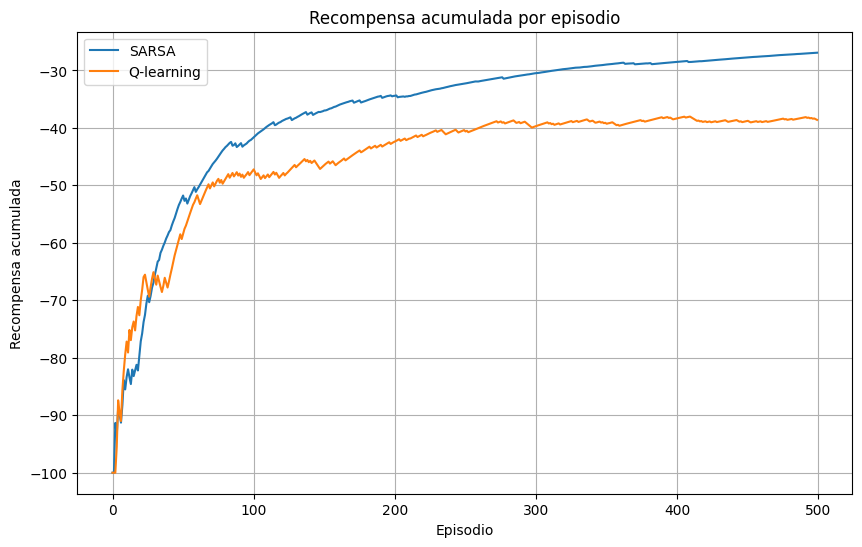

In [14]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_qlearning)

Veamos pasos por episodio

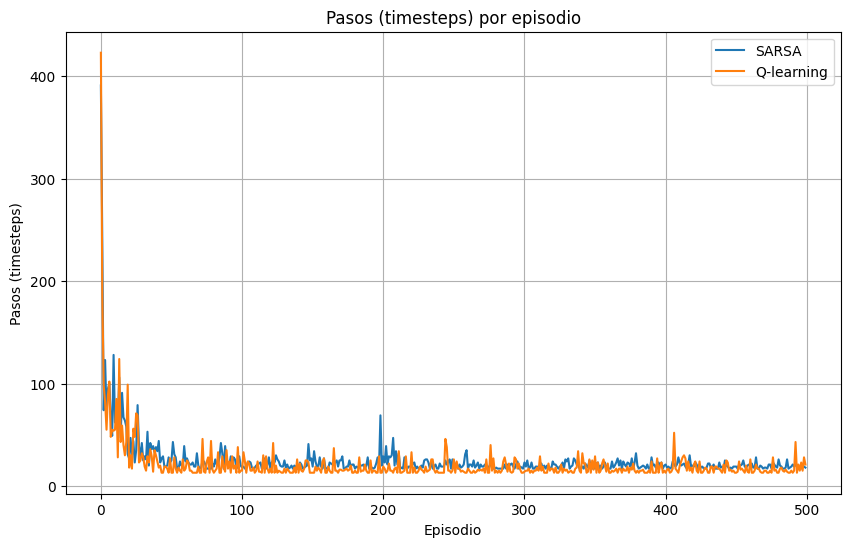

In [15]:
plot_steps_per_episode(timesteps_ep_sarsa,timesteps_ep_qlearning)

Suavizando...

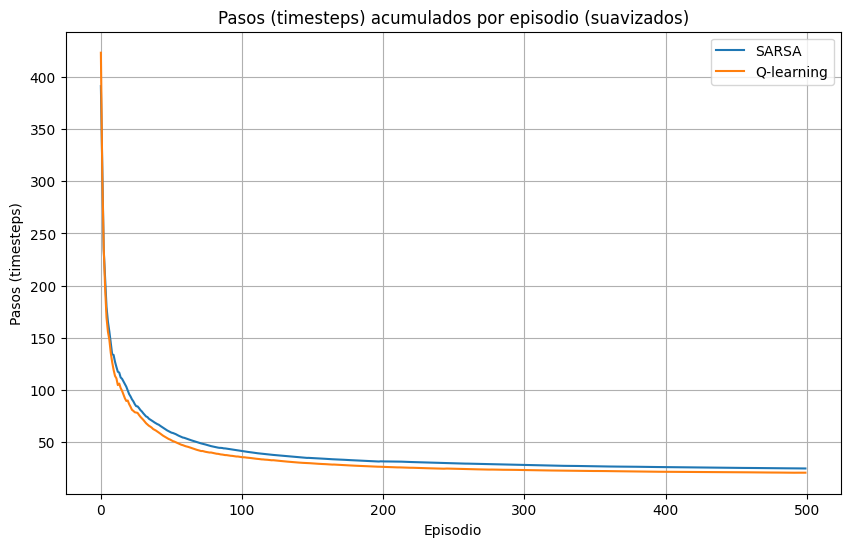

In [16]:
plot_steps_per_episode_smooth(timesteps_ep_sarsa, timesteps_ep_qlearning)

En el entorno "The Cliff", las curvas de pasos por episodio para SARSA y Q-learning son similares, indicando que ambos algoritmos convergen a políticas efectivas de manera comparable. Sin embargo, Las curvas de recompensa acumulada por episodio difieren, con SARSA alcanzando una recompensa acumulada de -30 y Q-learning de -40. Esta diferencia sugiere que SARSA adopta una política más segura y cautelosa, mientras que Q-learning tiende a buscar una política más óptima pero con mayores riesgos, ya que alcanza una recompensa más negativa.

Si el objetivo del problema fuera únicamente maximizar la recompensa acumulada a lo largo del tiempo, se podría concluir que SARSA tiene un mejor rendimiento con respecto a Q-learning.

No obstante, para una elección adecuada del algoritmo se debería considerar que SARSA es un algoritmo on-policy, lo que significa que aprende y sigue la política que está mejorando, lo que resulta en una política más segura. Mientras que, Q-learning es un algoritmo off-policy, lo que le permite aprender una política diferente a la que sigue, lo que puede llevar a políticas más arriesgadas en busca de recompensas más altas.

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

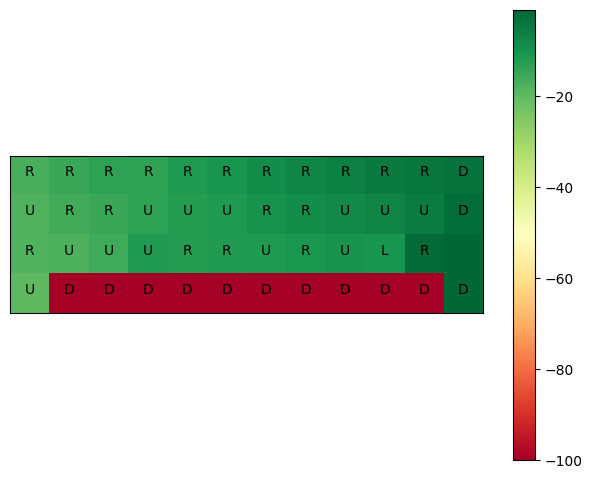


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [17]:
draw_value_matrix(sarsa_q)

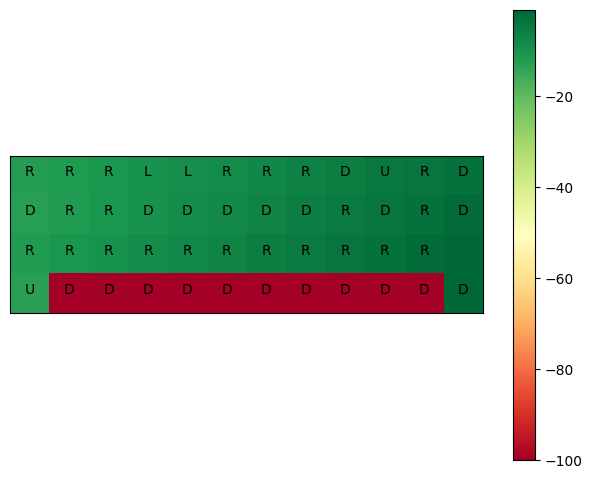


 Matriz de mejor acción-valor (en números): 

 [[ -12.31888313  -11.74616409  -10.95929743  -10.06409995   -9.23776351
    -8.48259366   -7.63726607   -6.74335694   -5.79852494   -4.8515625
    -3.96905543   -2.99549806]
 [ -12.90187539  -11.99159781  -10.99701954   -9.99889893   -8.9998608
    -7.99993342   -6.99997469   -5.99999514   -4.99999789   -3.99999933
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [18]:
draw_value_matrix(q_qlearning)

### 3. Búsqueda de hiperparámetros

Evaluaremos los hiperparámetros alpha y gamma para el algortimo SARSA que fue con el que optimizamos mejor el valor de recompensa acumulada.

Para no continuar modificando el código inicial, en el gráfico plot_reward_per_episode **el label 'Q-learning' en este caso representará la curva de el algoritmo SARSA con algún hiperparámetro modificado**.

#### alpha

In [19]:
sarsa_q = {}
hyperparameters_2 = {
    "alpha": 0.75,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_2, timesteps_ep_sarsa_2, reward_ep_sarsa_2 = run_sarsa(
    learning_function,
    hyperparameters_2,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)


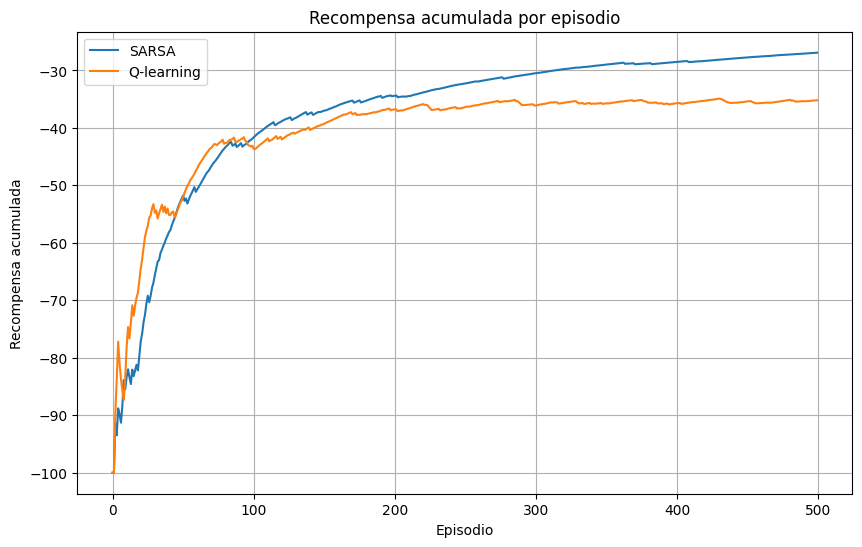

In [20]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_2)

In [21]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
sarsa_q = {}
hyperparameters_3 = {
    "alpha": 0.25,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_3, timesteps_ep_sarsa_3, reward_ep_sarsa_3 = run_sarsa(
    learning_function,
    hyperparameters_3,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)


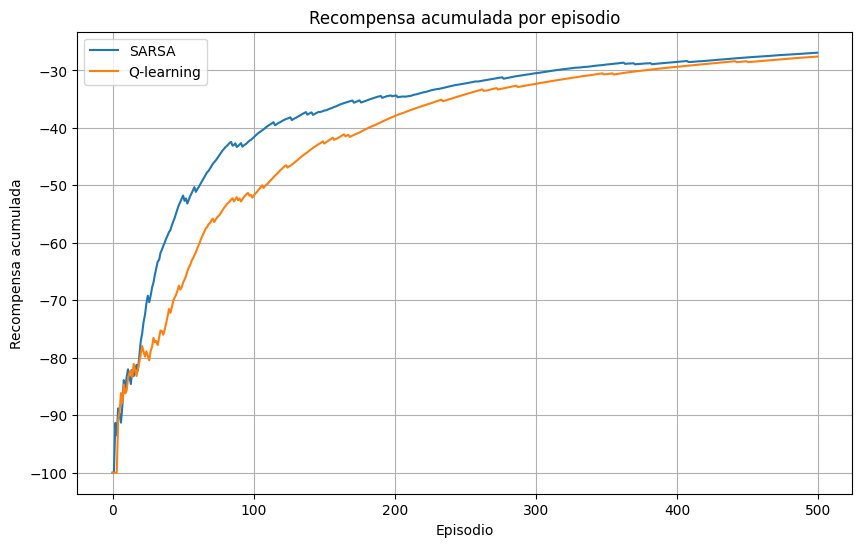

In [22]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_3)

Como se muestra en los gráficos, la selección del valor de la tasa de aprendizaje, alpha, al entrenar dependerá del equilibrio deseado entre velocidad y calidad del aprendizaje.

Valores altos de alpha pueden conducir a convergencia rápida pero políticas menos efectivas, mientras que valores bajos pueden llevar a convergencia lenta pero políticas más estables y óptimas.

##### gamma


In [32]:
sarsa_q = {}
hyperparameters_4 = {
    "alpha": 0.5,
    "gamma": 0.75,
    "epsilon": 0.1,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_4, timesteps_ep_sarsa_4, reward_ep_sarsa_4 = run_sarsa(
    learning_function,
    hyperparameters_4,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)

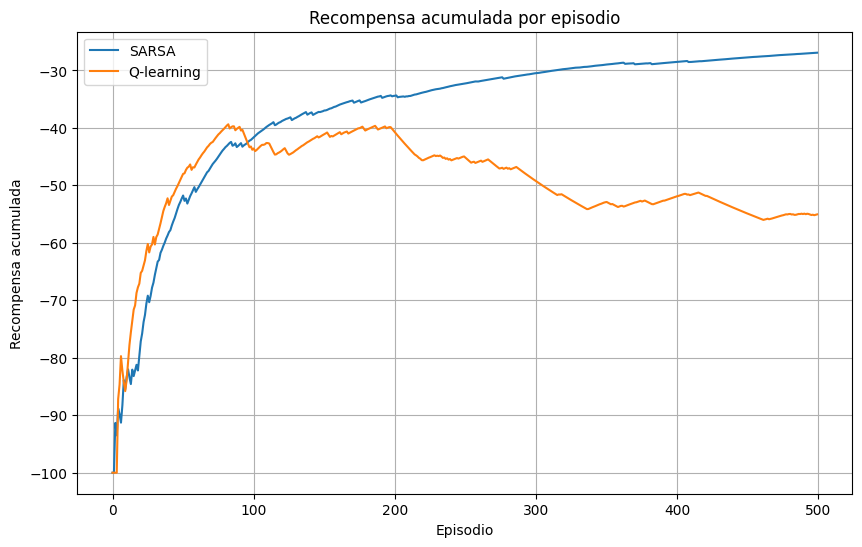

In [33]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_4)

In [34]:
sarsa_q = {}
hyperparameters_5 = {
    "alpha": 0.5,
    "gamma": 0.5,
    "epsilon": 0.1,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_5, timesteps_ep_sarsa_5, reward_ep_sarsa_5 = run_sarsa(
    learning_function,
    hyperparameters_5,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)

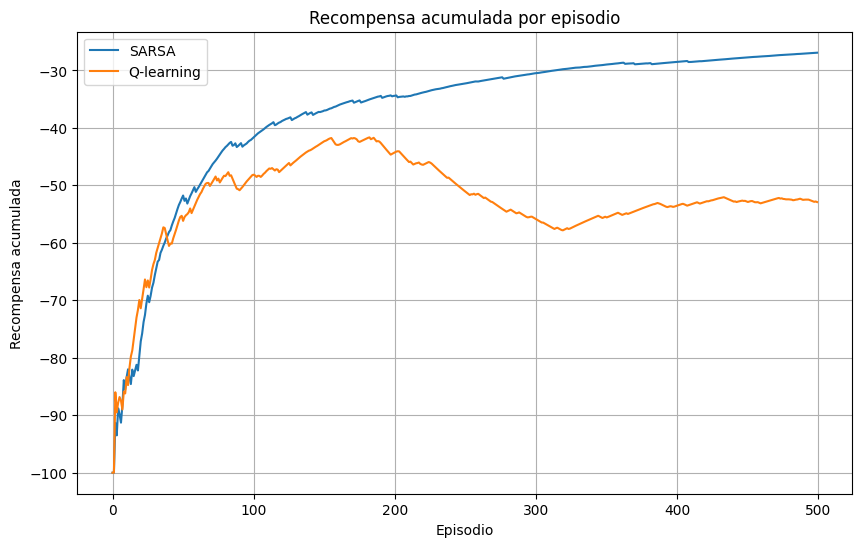

In [35]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_5)

El factor de descuento, gamma, determina cuánta relevancia se le asigna a las recompensas futuras en relación con las recompensas actuales. En las curvas de recompensa acumulada podemos destacar que a medida que disminuye gamma, las curvas inicialmente siguen una tendencia similar, pero luego alcanzan un máximo y comienzan a decrecer sin estabilizarse en un valor final. Este comportamiento se acentúa más a medida que disminuye gamma.

Esto nos muestra cómo gamma influye en la forma en que el algoritmo SARSA valora las recompensas a largo plazo, y un valor demasiado bajo puede hacer que el agente no dé suficiente importancia a las recompensas futuras, lo que afecta su comportamiento y su capacidad para aprender políticas efectivas.

#### epsilon

In [27]:
sarsa_q = {}
hyperparameters_6 = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.25,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_6, timesteps_ep_sarsa_6, reward_ep_sarsa_6 = run_sarsa(
    learning_function,
    hyperparameters_6,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)

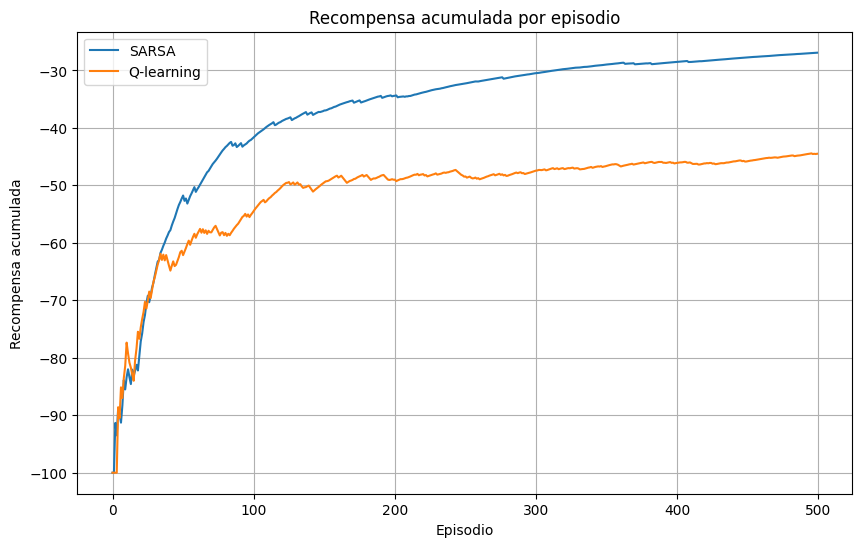

In [28]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_6)

In [29]:
sarsa_q = {}
hyperparameters_7 = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.5,
    "tau": 25,
}
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_per_episode_sarsa_7, timesteps_ep_sarsa_7, reward_ep_sarsa_7 = run_sarsa(
    learning_function,
    hyperparameters_7,
    episodes_to_run,
    env,
    actions,
    sarsa_q,
    random_state
)

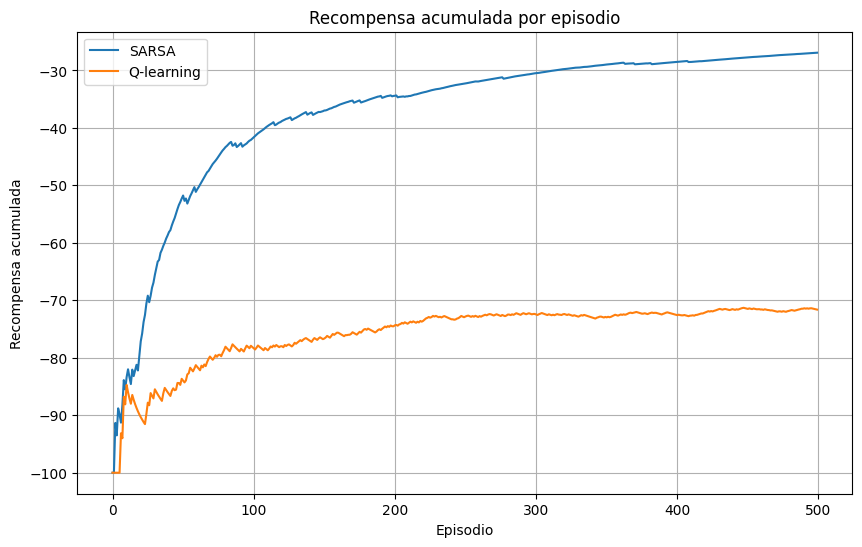

In [30]:
plot_reward_per_episode(reward_ep_sarsa,reward_ep_sarsa_7)

La elección de epsilon influye en el equilibrio entre la explotación de lo ya aprendido por el agente y la exploración de nuevas acciones.

Un valor de epsilon bajo tiende a generar un comportamiento más cauteloso y seguro por parte del agente, lo que puede llevar a una recompensa acumulada más baja pero estable. Mientras que, valores más altos de epsilon pueden hacer que el agente sea más propenso a explorar y tomar riesgos, lo que puede llevar a una recompensa acumulada más negativa.


In [31]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN